# _Review of machine learning algorithms for binary image classification_

The success of Deep learning is essentially due to outperforming other machine learning algorithms in the task of image classification[6].That's why, In this repository, we will use binary image classification to benchmark different machine learning algorithms including deep learning. 
We will Investigate how "classical" ML algorithms can be deployed to tackle this problem, compare them and see how their hyperparameters can be tuned to increase their performance. We will follow the same path with the deep learning approach.
    
The workflow is designed as follow :
    
- Import and visualize dataset (airplanes and cars images from the opensource dataset CIFAR-10). 
- Feature extraction and dimensionality reduction.
- Testing different ML algorithms.
- Convolutional neural networks.
- Conclusion.
    

#  Import and visualize dataset :
the dataset used is images of airplanes and cars extracted from the opensource dataset CIFAR-10.(For more informations about the dataset please refer to the official [website](https://www.cs.toronto.edu/~kriz/cifar.html).)
We will only retain the airplanes and cars images where we will use 10000 images for training and 2000 for testing.
the piece of code named "create_data.py" extract the images from the original dataset, transform them from RGB to
grayscale and save them in a standard format (X_train,y_train,X_test,y_test).
        
you can then load data and visualize images like this:
        
       
        

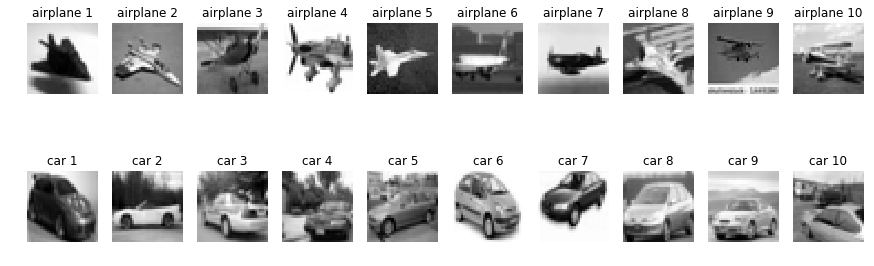

In [1]:
def load_data(filename):
    import pickle
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return (data['X_train'],data['X_test'],data['y_train'],data['y_test'])

X_train, X_test, y_train, y_test =load_data("C:/XXX/data")#enter your path name for the file 'data' 

# print(X_train.shape) # (10000,32,32)
# print(X_test.shape) # (2000,32,32)

import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2, 10, figsize=(15, 5))
axes=axes.ravel()
for i in range(int(len(axes)/2)):
    axes[i].axis('off')
    axes[i].imshow(X_train[i], cmap=plt.cm.gray)
    title = "airplane {}".format(i+1)
    axes[i].set_title(title)
    axes[-i-1].axis('off')
    axes[-i-1].imshow(X_train[-i-1], cmap=plt.cm.gray)
    title = "car {}".format(int(len(axes)/2)-i)
    axes[-i-1].set_title(title)

plt.show()


#   Feature extraction and dimensionality reduction
        
Deploying classical ML algorithms directly on the data is generally a bad idea, especially when dealing with images.
Usually we want to extract "features" from our images that explain the data better than the raw representation
in pixel intensities. One common feature used for images is Histogram of Oriented Gradients(H.O.G).This technique 
counts occurrences of gradient orientation in localized portions of an image (please refer to this [wikipedia](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) page for more technical details ,
and [here](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) for the algorithm overview.)
        
We will use Principal component analysis (PCA) for dimensionality reduction and also for noise reduction
(again refer to the [wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis) webpage for more details), this clearly improves the performance of the classifier.
        
            

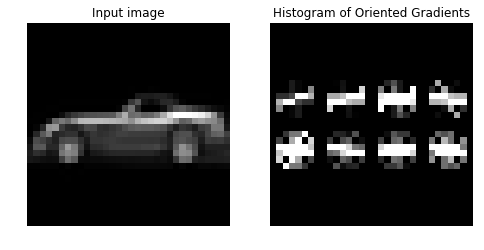

In [2]:
#This piece of code aims to show how to construct a HOG feature vector and how to visualize the result using
#the library scikit-image

from skimage.feature import hog
from skimage import exposure

fd, hog_image = hog(X_train[7008].astype('int32'), orientations=8, pixels_per_cell=(8,8),
                    cells_per_block=(1, 1), visualize=True, multichannel=False,block_norm='L2-Hys')
#fd store the HOG feature vector,while hog_image store the erconstructed image of HOG

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(X_train[7008].astype('int32'), cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
#extract HOG features for training and testing data
HOG_train=[]
HOG_test=[]
for i in range(len(X_train)):
        HOG_train.append (hog(X_train[i].astype('int32'), orientations=36, pixels_per_cell=(4,4),block_norm="L2-Hys",
                    cells_per_block=(1,1), visualize=False, multichannel=False))
for i in range(len(X_test)):
        HOG_test.append(hog(X_test[i].astype('int32'), orientations=36, pixels_per_cell=(4,4),block_norm="L2-Hys",
                    cells_per_block=(1,1), visualize=False, multichannel=False))
HOG_train=np.reshape(HOG_train,(len(HOG_train),len(HOG_train[0])))
HOG_test=np.reshape(HOG_test,(len(HOG_test),len(HOG_test[0])))

#retain the the 50 first principal components
pca=PCA(n_components=50)
pca.fit(HOG_train)
HOG_pca_train=pca.transform(HOG_train)
HOG_pca_test=pca.transform(HOG_test)

#Now we are good to test ML algorithms !

#   Testing different ML algorithms
        
The algorithms chosen for this task are :
            1. K-nearest neighbors 
            2. logistic regression 
            3. decision tree and Random forest
            4. multilayer perceptron (neural network)
Scikit-learn is a popular and opensource ML library ,and contains a comprehensive [documentation](http://scikit-learn.org/stable/). This is what we will use.
 Some basic preprocessing (standardization or normalization) will be used depending on the needs of each algorithm.
        
##       1. K-nearest neighbors

The k-NN algorithm is arguably the simplest machine learning algorithm. Building the model consists 
only of storing the training dataset. To make a prediction for a new data point, the algorithm
finds the closest data points in the training dataset: its “nearest neighbors.”
        
In principle, there are two important parameters to the KNeighbors classifier: the
number of neighbors and how you measure distance between data points. In practice,using a small number 
of neighbors like three or five often works well, but you should certainly adjust this parameter.[1] 
        
This simple algorithm can perform well on this task after extracting features and principal components from these features. Though it's important to say that while the nearest k-neighbors algorithm is easy to understand, 
it is not often used in practice, due to prediction being slow and its inability to handle many features.
        

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=10)#using few neighbors corresponds to high model complexity 
# and using many neighbors corresponds to low model complexity.simpler models generalize better 
# on unseen data.you may try several n_neighbors values and see how it behaves on the test data.

knn.fit(HOG_pca_train,y_train)
print("the score of the k-nn classifier over our test dataset is :{}% accuracy".format(100*knn.score(HOG_pca_test,y_test)))

the score of the k-nn classifier over our test dataset is :91.14999999999999% accuracy


##       2. Logistic regression
Logistic Regression is one of the basic and popular algorithm to solve a classification problem. 
It is named as ‘Logistic Regression’, because it’s underlying technique is quite the same as Linear Regression.
The term “Logistic” is taken from the Logit function that is used in this method of classification.[3]
Linear models often perform well when the number of features is large compared to the number of samples.They are also often used on very large datasets, simply because it’s not feasible to train other models.[1]
We will not review the math behing logistic regression here ,instead i will refer you to this [blogpost](https://medium.com/deep-math-machine-learning-ai/chapter-2-0-logistic-regression-with-math-e9cbb3ec6077) for this.
     
finally ,we will use scikit-learn library to fit Logistic regression model on our data,and it's important to notify
that scikit-learn performs a Ridge regularization (by default,or you can use "Lasso" regularization) version of the
regression.The regularizations aims to produce simpler models that less overfit to the training data.
        
standaridzation is highly recommanded when using logistic regression.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
HOG_pca_scaled_train = scaler.fit_transform(HOG_pca_train)
HOG_pca_scaled_test = scaler.fit_transform(HOG_pca_test)

lr=LogisticRegression(C=100)# the bigger C value is the bigger is regularization term,the simpler is the model !
lr.fit(HOG_pca_scaled_train,y_train)
print("the score of the Logistic regression classifier over our test dataset is :{}% accuracy".format(100*lr.score(HOG_pca_scaled_test,y_test)))

the score of the Logistic regression classifier over our test dataset is :88.2% accuracy


##       3. decision trees and random forests

 Decision trees are widely used models for classification and regression tasks. Essentially, they learn a hierarchy of if/else questions, leading to a decision.[1] A decision tree is a tree where each node represents a feature(attribute), each link(branch) represents a decision(rule) and each leaf represents an outcome(categorical or continuous value)[4].
        
Like other algorithms ,decision tree depends on a crucial parameter that prevent from overfitting: the maximum
depth of the tree. If we don't restrict the maximum depth of the tree it will be deep enough to memorize all
data points and can therefore achieve a 100% on the training set ,but behave poorly at the test set.
        
Random forests are another effective way to address this problem. A random forest is essentially a collection of decision trees,where each tree is slightly different fromthe others. The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amountof overfitting by averaging their results.[1]
        
Random forests is currently among the most widely used machine learning methods. They are very powerful, often work well without heavy tuning of the parameters, and don’t require scaling of the data.

In [31]:
from sklearn.tree import DecisionTreeClassifier

tree=DecisionTreeClassifier(max_depth=10)
tree.fit(HOG_pca_train,y_train)
print("the score of the decision tree classifier over our test dataset is :{}% accuracy".format(100*tree.score(HOG_pca_test,y_test)))

from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(n_estimators=100,max_depth=15,random_state=0)
forest.fit(HOG_pca_train,y_train)
print("the score of the random forest classifier over our test dataset is :{}% accuracy".format(100*forest.score(HOG_pca_test,y_test)))

the score of the decision tree classifier over our test dataset is :83.39999999999999% accuracy
the score of the random forest classifier over our test dataset is :88.85% accuracy


##       4. Multilayer perceptron (neural networks)

A family of algorithms known as neural networks has recently seen a revival under the name “deep learning”. While deep learning shows great promise in many machine learning applications, deep learning algorithms are often tailored very carefully to a specific use case. Here, we will apply some relatively simple methods, namely multilayer perceptrons that can serve as a starting point for more involved deep learning methods(Convolutional neural networks that we will talk about later).Multilayer perceptrons (MLPs) are also known as (vanilla) feed-forward neural networks, or sometimes just neuralnetworks.[1]
        
When applying deep learning a lot of hyperparameters can be tuned the results can change drastically from
one hyperparameters configuration to another. Even there's no mathematical rule that ensures optimal performance
you cann follow general guidelines that you can found in this excellent [blogpost](https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607) or simply by practicing !
        

In [7]:
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
HOG_pca_scaled_train = scaler.fit_transform(HOG_pca_train)
HOG_pca_scaled_test = scaler.fit_transform(HOG_pca_test)

NN=MLPClassifier(solver='lbfgs',activation='logistic',hidden_layer_sizes=(40),alpha=10,momentum=0.9, random_state=0)
NN.fit(HOG_pca_scaled_train,y_train)
print("the score of the neural network classifier over our test dataset is :{}% accuracy".format(100*NN.score(HOG_pca_scaled_test,y_test)))

the score of the neural network classifier over our test dataset is :92.80000000000001% accuracy


#  Convolutional neural networks :
## CNNs in a nutshell:

CNN is used as the default model for anything to deal with images. The fundamental difference between a densely connected layer and a convolution layer is this: 
Dense layers learn global patterns in their input feature space (for example,when dealing with images you
have to extract some specific features like H.O.G or edge detection ), whereas convolution layers actually learn 
these features by themselves.
Use of CNN helps to reduce the number of parameter required for images over the regular NN. but the key feature of CNNs is that they help to do the parameter sharing so that it can possess translation invariance.
A rapid and clear explanation about the CNNs can be found [here](https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148).

## Implementation:

Despite the incredible results achieved by CNNs, Tuning these networks to get them really work can be really fastidious:
 - There's a lot of parameters to care about (filter size, number of filters, whether to do dropout or not, activation functions ...).
 - Images are a high dimensional data and you need a lot of them to train your networks so it is very computationally expensive. Commonly GPUs are preferred for this kind of task. 

Reproducing existing working CNN architectures(from famous Papers[5] or books[2]) is often the most suitable starting point.
after tuning the network the best accuracy on the test data I could achieve was about 95%.This is not that great for a binary image classification but it's quiet better than other algorithms.Though ,better tuning can be done through:
- Data augmentation ,take a look at this keras [documentation](https://keras.io/preprocessing/image/).
- Extracting features using a pretrained CNN.
- GOING DEEPER!


 
        

In [33]:
from keras import layers
from keras import models
from keras.utils import to_categorical
from keras import optimizers

#rescaling
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train.reshape(len(X_train),len(X_train[0])**2))
X_scaled_test = scaler.fit_transform(X_test.reshape(len(X_test),len(X_test[0])**2))

#reshaping inputs to be 3D tensors (width ,height and number of channels)
X_reshaped_train=X_scaled_train.reshape((len(X_train),len(X_train[0]),len(X_train[0]),1))
X_reshaped_test=X_scaled_test.reshape((len(X_test),len(X_test[0]),len(X_test[0]),1))
y_cat_train=to_categorical(y_train)
y_cat_test=to_categorical(y_test)


#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model = models.Sequential()
model.add(layers.Conv2D(20, (3, 3), activation='relu', input_shape=(len(X_train[0]), len(X_train[0]), 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(10, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(10, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])   
history=model.fit(X_reshaped_train, y_cat_train, epochs=10, batch_size=10,validation_data=(X_reshaped_test,y_cat_test))                    

#training on more eopchs produce an accuracy of 95 % but would take a lot of time to execute


Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 221s 22ms/step - loss: 0.4551 - acc: 0.7853 - val_loss: 0.3192 - val_acc: 0.8780
Epoch 2/10
10000/10000 [==============================] - 222s 22ms/step - loss: 0.3304 - acc: 0.8587 - val_loss: 0.2681 - val_acc: 0.9005
Epoch 3/10
10000/10000 [==============================] - 220s 22ms/step - loss: 0.2749 - acc: 0.8853 - val_loss: 0.2304 - val_acc: 0.9010
Epoch 4/10
10000/10000 [==============================] - 223s 22ms/step - loss: 0.2549 - acc: 0.8962 - val_loss: 0.2042 - val_acc: 0.9175
Epoch 5/10
10000/10000 [==============================] - 227s 23ms/step - loss: 0.2370 - acc: 0.9018 - val_loss: 0.1743 - val_acc: 0.9285
Epoch 6/10
10000/10000 [==============================] - 224s 22ms/step - loss: 0.2194 - acc: 0.9085 - val_loss: 0.1627 - val_acc: 0.9335
Epoch 7/10
10000/10000 [==============================] - 222s 22ms/step - loss: 0.2134 - acc: 0.9133 - val_loss: 0.1

#  Conclusion :
Comparing Deep learning approach and classical approach for image classification can be challenging, since each of the classical algorithms has its pros and cons. Nonetheless one must say that Convolutional neural networks are currently the state-of-the-art for image classification. The tuning is a little bit harder and the training takes a lot of time, but when we get them to work they can be very powerful and the prediction is quiet fast.

 

# References:
 - [1] Introduction to machine learning with python,Andreas C. Müller & Sarah Guido.
 - [2] deep learning with python,François Chollet.
 - [3] https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102
 - [4] https://medium.com/deep-math-machine-learning-ai/chapter-4-decision-trees-algorithms-b93975f7a1f1
 - [5] https://www.nvidia.cn/content/tesla/pdf/machine-learning/imagenet-classification-with-deep-convolutional-nn.pdf
 - [6] http://fortune.com/ai-artificial-intelligence-deep-machine-learning/